In [1]:
import matplotlib.pyplot as plt
from statistics import mean

i: 0 completed


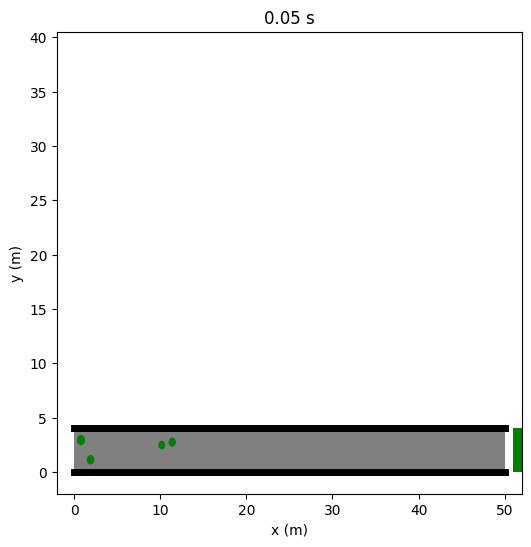

In [1]:
# Author: Anders Johansson (a.johansson@bristol.ac.uk)
# Description: This file contains functionality to simulate pedestrian crowds.
# Date: 2024-10-10

from world import World, normalise_vector, vector_length, get_nearest_position
import math
import numpy as np


def pedestrian_initialisation(pedestrian, polygons, statistics):
    pass

def update_directions(pedestrians, boundaries, polygons):
    for i, ped in pedestrians.items():
        destination_polygon_centroid = polygons[ped.destination]["nodes"].mean(axis=0)
        ped.desired_direction = normalise_vector(destination_polygon_centroid - ped.pos)

def process_interactions(pedestrians, boundaries, polygons):
    # Parameters
    tau = 0.5
    A_boundary_social, B_boundary_social = .5, 2
    A_boundary_physical = 50
    A_social, B_social = .5, 2
    A_physical = 4
    Lambda = 0.2
    for i, ped_i in pedestrians.items():
        ped_i.acc = (ped_i.desired_walking_speed*ped_i.desired_direction - ped_i.vel) * (1/tau)
        # Pairwise forces from other pedestrians
        for j, ped_j in pedestrians.items():
            if i!=j:
                distance = vector_length(ped_i.pos - ped_j.pos)
                tangent = normalise_vector(ped_i.pos - ped_j.pos)
                # Angular dependency
                vec_ij = normalise_vector(ped_j.pos - ped_i.pos)
                cos_phi = normalise_vector(ped_i.vel).dot(vec_ij)
                angular_dependency = Lambda + (1.0 - Lambda)*((1+cos_phi)/2.0)
                # Apply physical force
                if distance <= ped_i.radius+ped_j.radius:
                    ped_i.acc += A_physical*tangent
                # Apply social force
                if ped_i.group_name == 'group1':
                    ped_i.acc += A_social*angular_dependency*math.exp(-(distance)/B_social)*tangent

                # apply negative (attractive) force if both peds are group 2
                elif ped_i.group_name == 'group1' and ped_j.group_name == 'group2':
                    ped_i.acc -= A_social*angular_dependency*math.exp(-(distance)/B_social)*tangent

        
        # Forces from boundaries
        for boundary in boundaries:
            pos_b  = get_nearest_position(ped_i.pos, boundary)
            distance = vector_length(ped_i.pos - pos_b)
            tangent = normalise_vector(ped_i.pos - pos_b)
            # Apply physical boundary force
            if distance <= ped_i.radius:
                ped_i.acc += A_boundary_physical*tangent
            # Apply social boundary force
            ped_i.acc += A_boundary_social*math.exp(-(distance)/B_boundary_social)*tangent


# Define modelling scenario
corridor_width = 4
corridor_length = 50
world_definition = {
    "space": {
        "corridor": {"type": "rectangle", "coordinates": [0, 0, corridor_length, corridor_width], "colour": "gray", "add_boundaries": False},
        "right": {"type": "rectangle", "coordinates": [corridor_length+1, 0, corridor_length+2, corridor_width], "colour": "green", "add_boundaries": False},
    },
    "pedestrians": {
        "group1": {"source": "corridor", "destination": "right", "colour": "red", "birth_rate": 10, "max_count": 16},
        'group2': {'source': 'corridor', 'destination': 'right', 'colour': 'green', 'birth_rate': 99, 'max_count': 4}
    },
    "boundaries": [[0, 0, corridor_length, 0], [0, corridor_width, corridor_length, corridor_width]],
    "periodic_boundaries": {"axis": "x", "pos1": 0, "pos2": corridor_length},
    "functions": {
        "update_directions": update_directions,
        "process_interactions": process_interactions,
        "pedestrian_initialisation": pedestrian_initialisation
    }
}

world = World(world_definition)

statistics = []

# Run simulation for 60 seconds
for i in range(600):
    print(f'i: {i} completed')
    world.update(0.05)
    # for i_ped, ped in world.pedestriants.items():
    if i%10==0:
        # pass

        statistics.append({'time': world.time,
                        'pedestrians': [{'id': i_ped,
                                            'position': ped.pos,
                                            'velocity': ped.vel
                                            } for i_ped, ped in world.pedestrians.items()]
                        })


        
        # rendering doesn't work :(
        world.render()
        break


In [3]:
# get density of crowd
def Density(stats, width, length):
    # stats: stats object i create
    # width: corridor width
    # length: corridor length
    # area = width x length

    area = width * length
    rho = []
    for stat in stats:
        rhoTemp = {}
        rhoTemp['time'] = stat['time']
        rhoTemp['density'] = len(stat['pedestrians']) / area
        rho.append(rhoTemp)
    
    return rho


In [4]:
def Speed(stats):
    # stats: stats object i created
    # returns average velocity of all pedestriants for each timestep given

    v = []
    for stat in stats:
        vTemp = {}
        vTemp['time'] = stat['time']
        vXTemp = sum([stat['pedestrians'][x]['velocity'][0] for x in range(len(stat['pedestrians']))]) / len(stat['pedestrians'])
        vYTemp = sum([stat['pedestrians'][x]['velocity'][1] for x in range(len(stat['pedestrians']))]) / len(stat['pedestrians'])

        vTemp['velocity'] = [vXTemp, vYTemp]

        v.append(vTemp)
    
    return v


In [5]:
def Flow(stats, width, length, direction = 'x'):
    # direction : either 'x' or 'y', determines which orientation to use for 1D flow
    # returns crowd flow for each timestep given
    # calls Density() and Speed()

    density = Density(stats, width, length)
    velocity = Speed(stats)

    flow = []
    # iterate through each timestep
    for rho, v in zip(density, velocity):
        flowTemp = {}
        # check if rho and v have the same t, convert to string to avoid f.p. error
        if str(rho['time']) != str(v['time']):
            pass
        else:
            flowTemp['time'] = rho['time']
            if direction == 'x':
                flowTemp['flow'] = rho['density'] * v['velocity'][0]
            elif direction == 'y':
                flowTemp['flow'] = rho['density'] * v['velocity'][1]
        
        flowTemp['time'] = rho['time']
        flowTemp['density'] = rho['density']
        flowTemp['velocity'] = v['velocity']

        flow.append(flowTemp)
    
    return(flow)

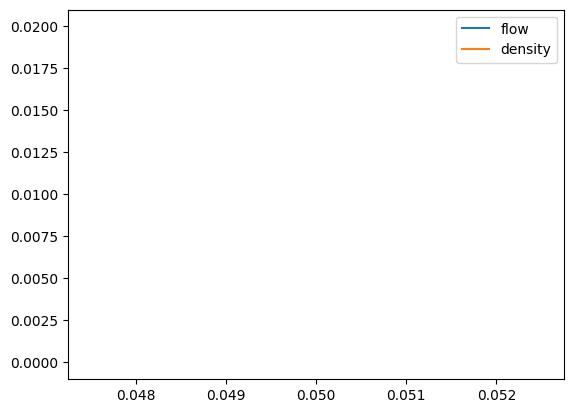

In [6]:
# plot flow, density, and velocity stuff
fig, ax = plt.subplots()

flow = Flow(statistics, corridor_width, corridor_length)

x = [t['time'] for t in flow]

ax.plot(x, [t['flow'] for t in flow], label='flow')
ax.plot(x, [t['density'] for t in flow], label='density')
# ax.plot(x, [t['velocity'][0] for t in flow], label='X velocity')

ax.legend()


Varying the simulation to be bi-directional

In [8]:
alpha = np.linspace(0, 1, 5)   # fraction of people going left
L = 10      # length of corridor
w = 2       # width
N = 40      # people count

rho = []    # density
v = []      # x-velocity
flow = []   # flow

for a in alpha:
    # define world
    world_definition = {
        "space": {
            "corridor": {"type": "rectangle", "coordinates": [0, 0, L, w], "colour": "gray", "add_boundaries": False},
            "right": {"type": "rectangle", "coordinates": [L+1, 0, L+2, w], "colour": "green", "add_boundaries": False},
            'left': {'type': 'rectangle', 'coordinates': [-1, 0, -2, w], 'colour': 'green', 'add_boundaryes': False}
        },
        "pedestrians": {
            "group1": {"source": "corridor", "destination": "right", "colour": "red", "birth_rate": 99, "max_count": int(N*a)},
            'group2': {'source': 'corridor', 'destination': 'left', 'colour': 'green', 'birth_rate': 99, 'max_count': int(N*(1-a))}
        },
        "boundaries": [[0, 0, L, 0], [0, w, L, w]],
        "periodic_boundaries": {"axis": "x", "pos1": 0, "pos2": L},
        "functions": {
            "update_directions": update_directions,
            "process_interactions": process_interactions,
            "pedestrian_initialisation": pedestrian_initialisation
        }
    }

    # Run simulation for 45 seconds
    for i in range(900):
        world.update(0.05)
        # for i_ped, ped in world.pedestriants.items():
        if i%10==0:
            # record statistics every second
            statistics.append({'time': world.time,
                            'pedestrians': [{'id': i_ped,
                                                'position': ped.pos,
                                                'velocity': ped.vel
                                                } for i_ped, ped in world.pedestrians.items()]
                            })

    # get average velocity, density, and flow
    flowTemp = Flow(statistics, w, L)

    # pull out average stats for entire simulation
    # print([x for x in statistics])
    rho.append(mean([x['density'] for x in flowTemp]))
    v.append(mean(x['velocity'][0] for x in flowTemp))
    flow.append(mean(x['flow'] for x in flowTemp))

[0.   0.25 0.5  0.75 1.  ]
[0.9758241758241758, 0.9878453038674033, 0.9918819188191882, 0.9939058171745152, 0.9951219512195122]


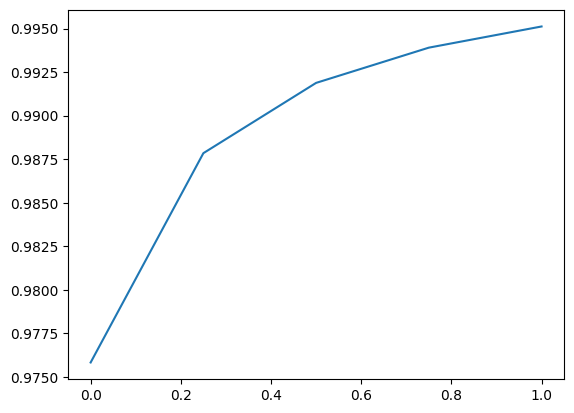

In [9]:
print(alpha)
print(rho)
plt.plot(alpha, rho)